In [1]:
!pip install evaluate
!pip install transformers
!pip install datasets
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.0 MB/s eta 0:00:00


In [2]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import evaluate
import optuna

In [3]:
pss_data = pd.read_csv('/content/subset_file_50000_100000.csv')

# Display first few rows of the dataset
pss_data.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,5XFV,A,MAHHHHHHSAALEVLFQGPGSMSLKVNILGHEFSNPFMNAAGVLCT...,CCCCCCCCCCCCCCCCCCCCCCCCCEEETTEEESSSEEECTTSSCS...,CCCCCCCCCCCCCCCCCCCCCCCCCEEECCEEECCCEEECCCCCCC...,334,False
1,4R9X,A,MLEVIATCLEDVKRIERAGGKRIELISSYTEGGLTPSYAFIKKAVE...,CEEEEESSHHHHHHHHHTTCCEEEECBCGGGTCBCCCHHHHHHHHH...,CEEEEECCHHHHHHHHHCCCCEEEECECHHHCCECCCHHHHHHHHH...,233,False
2,5VAX,A,GSMAHAGRTGYDNREIVMKYIHYKLSQRGYEWDDGDDVEENRTEAP...,CCCCCCCCCCCCHHHHHHHHHHHHHHTTTCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCCCCC...,168,False
3,5LSJ,D,MGTLQKCFEDSNGKASDFSLEASVAEMKEYITKFSLERQTWDQLLL...,CCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHH...,CCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHH...,178,False
4,2J5I,B,MSTYEGRWKTVKVEIEDGIAFVILNRPEKRNAMSPTLNREMIDVLE...,CCCCCCCCSSEEEEEETTEEEEEECCGGGTTCBCHHHHHHHHHHHH...,CCCCCCCCCCEEEEEECCEEEEEECCHHHCCCECHHHHHHHHHHHH...,276,False


In [4]:
# Keep the dataset as is (no oversampling)
balanced_data = pss_data.copy()

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the class distribution (unchanged)
balanced_distribution = balanced_data['sst3'].value_counts()
print(balanced_distribution)

sst3
CECCHHHHHHHHHHCCCCCECCECHHHHHHHHHHHHCCECCCEEEECCCCEEEECCCCEECCCCCECCCCCCCCCCCCCEHHHHHCCCCHHHHHHHHHHHCCCCHHHHCHHHHHHCCCCCCHHHCCCCCC                                                                                                                                                              43
CCHHHHHHHHHCCEEEEEECCCCCEEEECCEEEECCCCHHHHHHHHHHHHCCCCCCECCHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHCCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHCCCHHHHHHHHHCCHHHHHCHHHHHHHHHHHHHCCCHHHCCC                                                                                                                            39
CCHHHHHHHHHCCEEEEEECCCCCEEEECCEEEECCCCHHHHHHHHHHHHCCCCCCECCHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHCCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHCCCHHHHHHHHHCCHHHHHCHHHHHHHHHHHHHCCCHHHCCC                                                                                                                            29
CCCCCCCCEEEEEEEEECCCCEEEEEECCEEEEEEECCEECCCCCCCCHHHHHHHHHHHHHHCCCEEEECCCCCCECCCCCEEEEEEECCEEHHHHHHHCCCCEECCCCCCCCCCHHHHHHH

In [5]:
pss_data_cleaned = pss_data.dropna(subset=['sst3'])

X = pss_data_cleaned['seq']  # Amino acid sequence
y = pss_data_cleaned['sst3']  # Secondary structure labels (C, E, H)

train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts, val_labels, test_size=0.5, random_state=42)

In [6]:
# Modify the model to use ESM2
model_name = "facebook/esm2_t30_150M_UR50D"  # ESM2 model

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors="pt"  # PyTorch tensors
    )

# Tokenize the datasets
train_encodings = tokenize_data(train_texts, tokenizer)
val_encodings = tokenize_data(val_texts, tokenizer)
test_encodings = tokenize_data(test_texts, tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
from datasets import Dataset
import torch

# Ensure labels are correctly mapped to integers
label_map = {'C': 0, 'E': 1, 'H': 2} # Helix(H), Sheet(E), Coil(C)

# Convert string labels (sequences) to a list of numeric labels for each residue and pad/truncate them
def prepare_labels(label_sequences, label_map, max_length, pad_value=-100):
    numeric_labels = []
    for seq in label_sequences:
        numeric_seq = [label_map.get(char, pad_value) for char in seq] # Use .get with pad_value for unknown chars
        # Truncate numeric sequence if longer than max_length
        truncated_seq = numeric_seq[:max_length]
        # Pad the numeric sequence
        padded_seq = truncated_seq + [pad_value] * (max_length - len(truncated_seq))
        numeric_labels.append(padded_seq)
    return numeric_labels

# Get max_length from tokenization for each split
train_max_length = train_encodings["input_ids"].shape[1]
val_max_length = val_encodings["input_ids"].shape[1]
test_max_length = test_encodings["input_ids"].shape[1]


train_labels_numeric_padded = prepare_labels(train_labels, label_map, train_max_length)
val_labels_numeric_padded = prepare_labels(val_labels, label_map, val_max_length)
test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)


# Convert the data into Hugging Face Dataset format with torch tensors
train_data = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"].clone().detach(),
    "attention_mask": train_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(train_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

val_data = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"].clone().detach(),
    "attention_mask": val_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(val_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

In [8]:
import torch
import torch.nn as nn
from transformers import AutoModelForTokenClassification

# Function to define the model and training arguments for Optuna optimization
class BiLSTMWithESM2(nn.Module):
    def __init__(self, transformer_model_name, lstm_hidden_dim, num_labels):
        super(BiLSTMWithESM2, self).__init__()

        # Load the transformer model (ESM2 in your case)
        self.transformer = AutoModelForTokenClassification.from_pretrained(transformer_model_name, num_labels=num_labels)

        # BiLSTM Layer
        self.lstm = nn.LSTM(
            input_size=self.transformer.config.hidden_size,  # ESM2 hidden size
            hidden_size=lstm_hidden_dim,  # Hidden size for the BiLSTM
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Final classification layer
        self.classifier = nn.Linear(lstm_hidden_dim * 2, num_labels)  # BiLSTM is bidirectional, so *2

    def forward(self, input_ids, attention_mask, labels=None):
        # Get the transformer outputs
        # Access the hidden states directly from the model output
        transformer_outputs = self.transformer(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # Extract the last hidden states from transformer (output is (batch_size, seq_length, hidden_size))
        # Access the last hidden states from the tuple of hidden states
        last_hidden_states = transformer_outputs.hidden_states[-1]

        # Pass the transformer outputs through the BiLSTM
        lstm_out, _ = self.lstm(last_hidden_states)

        # Use the output of the BiLSTM layer (last hidden state) for classification
        logits = self.classifier(lstm_out)

        # If labels are provided, compute the loss
        loss = None
        if labels is not None:
            # Compute cross-entropy loss
            loss_fct = nn.CrossEntropyLoss()
            # Flatten the tokens and labels for loss computation
            loss = loss_fct(logits.view(-1, self.transformer.config.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [9]:
# Initialize the model with BiLSTM and set hyperparameters
model = BiLSTMWithESM2(
    transformer_model_name="facebook/esm2_t30_150M_UR50D",  # ESM2 model
    lstm_hidden_dim=512,  # Size of LSTM hidden layer
    num_labels=3  # 3 classes (C, E, H)
)

# Function to define the model and training arguments for Optuna optimization
def create_model(params):
    model = BiLSTMWithESM2(
        transformer_model_name="facebook/esm2_t30_150M_UR50D",  # ESM2 model
        lstm_hidden_dim=256,  # Size of LSTM hidden layer
        num_labels=3  # 3 classes (C, E, H)
    )

    # Training arguments with hyperparameters to tune
    training_args = TrainingArguments(
        output_dir=f"./esm2_token_output", # Changed output directory name
        eval_strategy="epoch",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=32,
        num_train_epochs=params['epochs'],
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1", # Still using F1 as a metric
        greater_is_better=True,
        report_to="none",
    )
    return model, training_args

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Load evaluation metrics
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
accuracy_metric = evaluate.load("accuracy")

# Define the compute_metrics function to calculate accuracy, precision, recall, F1, and Q3 accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Flatten the predictions and labels and remove padding (label -100)
    flat_predictions = predictions.flatten()
    flat_labels = labels.flatten()

    # Filter out padding
    mask = flat_labels != -100
    filtered_predictions = flat_predictions[mask]
    filtered_labels = flat_labels[mask]

    # Compute Accuracy, Precision, Recall, F1, and Macro F1 on filtered data
    accuracy = accuracy_metric.compute(predictions=filtered_predictions, references=filtered_labels)
    precision = precision_metric.compute(predictions=filtered_predictions, references=filtered_labels, average="weighted")
    recall = recall_metric.compute(predictions=filtered_predictions, references=filtered_labels, average="weighted")
    f1 = f1_metric.compute(predictions=filtered_predictions, references=filtered_labels, average="weighted")

    # Calculate Q3 accuracy (percentage of correctly predicted residues in the sequence)
    q3_correct = sum(filtered_predictions == filtered_labels)
    q3_accuracy = q3_correct / len(filtered_labels) if len(filtered_labels) > 0 else 0.0


    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
        "q3_accuracy": q3_accuracy
    }

In [11]:
# Function for hyperparameter optimization
def objective(trial):
    # Define hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 6e-5),
        'batch_size': trial.suggest_int('batch_size', 8, 32),
        'epochs': trial.suggest_int('epochs', 2, 3)
    }

    # Create model and training args with hyperparameters
    model, training_args = create_model(params)

    # Trainer setup
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
    )

    # Train the model
    trainer.train()

    # Evaluate the model using the Trainer's evaluation method which uses compute_metrics
    eval_results = trainer.evaluate(val_data)

    # Get the F1 score from the evaluation results
    f1 = eval_results["eval_f1"] # Access the f1 metric calculated by compute_metrics

    return f1

In [12]:
# Set up Optuna study and perform hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

# Output the best hyperparameters
print("Best hyperparameters: ", study.best_trial.params)

[I 2025-09-20 12:27:25,983] A new study created in memory with name: no-name-d6504126-298f-487f-9480-5e5de9012c58
/tmp/ipython-input-3568967875.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 6e-5),
Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3568967875.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Q3 Accuracy
1,0.345100,0.327778,0.873073,0.873024,0.873073,0.873028,0.873073
2,0.290200,0.304350,0.883512,0.883483,0.883512,0.883468,0.883512
3,0.245500,0.302722,0.886116,0.886159,0.886116,0.886112,0.886116


[I 2025-09-20 14:00:27,791] Trial 0 finished with value: 0.8861124115876395 and parameters: {'learning_rate': 2.093130982854258e-05, 'batch_size': 21, 'epochs': 3}. Best is trial 0 with value: 0.8861124115876395.


Best hyperparameters:  {'learning_rate': 2.093130982854258e-05, 'batch_size': 21, 'epochs': 3}


In [13]:
# Now train the model with the best hyperparameters from Optuna
best_params = study.best_trial.params

# Create the model and training arguments directly using the best hyperparameters
model, training_args = create_model(best_params)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# Train the final model with the best hyperparameters
trainer.train()

Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3358710215.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Q3 Accuracy
1,0.344200,0.327169,0.873108,0.873125,0.873108,0.873106,0.873108
2,0.285400,0.304414,0.883214,0.883224,0.883214,0.883183,0.883214
3,0.250400,0.303059,0.885447,0.885504,0.885447,0.885432,0.885447


TrainOutput(global_step=5139, training_loss=0.31498032127472414, metrics={'train_runtime': 5594.4966, 'train_samples_per_second': 19.29, 'train_steps_per_second': 0.919, 'total_flos': 0.0, 'train_loss': 0.31498032127472414, 'epoch': 3.0})

In [14]:
from sklearn.metrics import classification_report

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q3_accuracy = eval_results["eval_q3_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]


# Print Q3 accuracy and F1 score
print("Q3 Accuracy: {:.4f}".format(q3_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))


# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix"] # Assuming 0: Coil, 1: Sheet, 2: Helix
# Explicitly specify the labels to report on
report_labels = [0, 1, 2] # Corresponding to Coil, Sheet, Helix

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

Q3 Accuracy: 0.8841
Weighted F1 Score: 0.8841

Classification Report:
              precision    recall  f1-score   support

        Coil       0.87      0.88      0.88    247790
       Sheet       0.89      0.87      0.88    126776
       Helix       0.89      0.90      0.90    168294

    accuracy                           0.88    542860
   macro avg       0.89      0.88      0.88    542860
weighted avg       0.88      0.88      0.88    542860



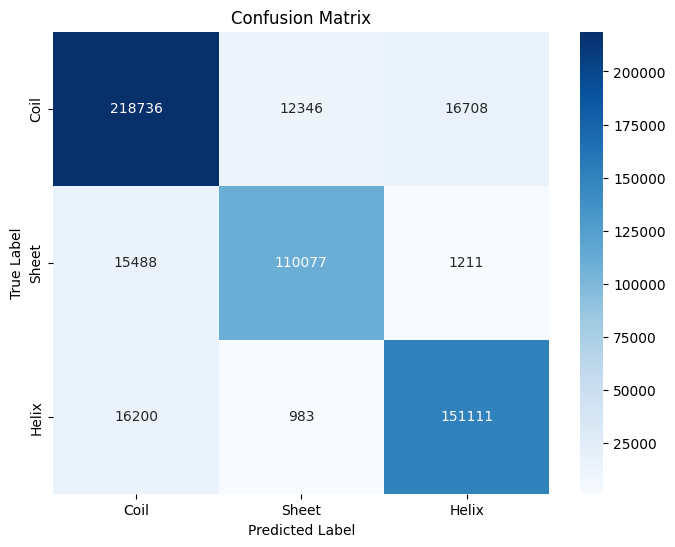

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [17]:
# # Define the path where you want to save the model in your Google Drive
# # Make sure this directory exists or is created.
# save_path = "/content/drive/MyDrive/esm2large_protein_secondary_structure_model"

# # Save the model and tokenizer using the trainer
# trainer.save_model(save_path)

# print(f"Model saved to {save_path}")